# Cartoon Face Generation with Variational Autoencoders

In [1]:
import logging
import torch 

from aicraft.utils.loaders import CartoonFacesLoader
from aicraft.utils.visualise import Visualisations

from aicraft.models.vae.faces.model import FaceVAE
from aicraft.utils.loss import CustomLosses
from aicraft.models.AutoEncoderTrainers import VaeTrainer


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DEBUG_MODE = True

if torch.cuda.is_available():
    logger.info("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    logger.info("Using MPS")
    device = torch.device("mps")
else:
    logger.info("Using CPU")
    device = torch.device("cpu")

device

INFO:__main__:Using MPS


device(type='mps')

## Load data

In [2]:
data_loader = CartoonFacesLoader()
train_loader, val_loader, test_loader = data_loader.get_loaders(batch_size=128)

INFO:aicraft.utils.loaders:Using provided means and stds for the cartoon faces dataset...
INFO:aicraft.utils.loaders:
means: [0.924, 0.884, 0.854]
stds: [0.181, 0.23, 0.276]


INFO:__main__:Shape of batch: torch.Size([128, 3, 512, 512])


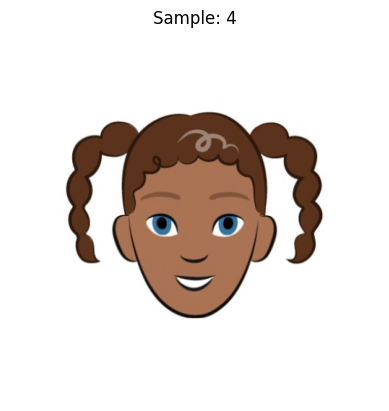

In [3]:
_batch, _labels = next(iter(train_loader))
_sample, label = _batch[0], _labels[0]
logger.info(f"Shape of batch: {_batch.shape}")
Visualisations.show_3_channel_image(_sample, f"Sample: {label}")

## Defining the Models

In [6]:
face64 = FaceVAE(embedding_size=64)
face256 = FaceVAE(embedding_size=256)

INFO:__main__:Initial Loss Estimate: (tensor(369.3914, grad_fn=<AddBackward0>), tensor(360.8443, grad_fn=<MulBackward0>), tensor(8.5471, grad_fn=<MeanBackward0>))


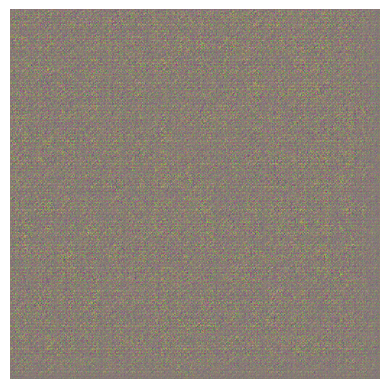

In [7]:
# Running the model
_mu, _log_var = face64.encoder(_batch)
z = face64.sampling(_mu, _log_var)
_batch_reconstructed = face64.decoder(z)

# Computing loss
_l = CustomLosses.vae_loss(_batch_reconstructed, _batch, _mu, _log_var)
logger.info(f"Initial Loss Estimate: {_l}")

# Visualising the reconstructed image
Visualisations.show_3_channel_image(_batch_reconstructed[0])

## Training the Model

### Face64

In [8]:
optimiser = torch.optim.Adam(face64.parameters(), lr=0.0001)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.80)
exponential_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
VaeTrainer.train(
    tl=test_loader, 
    vl=val_loader, 
    model=face64, 
    loss_fn=CustomLosses.vae_loss_with_rmse, 
    optimiser=optimiser, 
    scheduler=step_scheduler, 
    epochs=10, 
    device=device
)

VAE Training: 100%|██████████| 79/79 [01:33<00:00,  1.18s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 1, Loss: 414.7831903771509, Validation Loss: 371.9473714707773
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 1: [0.0001]
VAE Training: 100%|██████████| 79/79 [01:45<00:00,  1.33s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 2, Loss: 347.3839999814577, Validation Loss: 317.76293056826046
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 2: [0.0001]
VAE Training: 100%|██████████| 79/79 [01:57<00:00,  1.49s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 3, Loss: 299.30942892726466, Validation Loss: 276.5608338947538
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 3: [0.0001]
VAE Training: 100%|██████████| 79/79 [01:47<00:00,  1.36s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 4, Loss: 257.8964783873739, Validation Loss: 243.99354147609276
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 4: [0.0001]
VAE Training: 100%|██████████| 79/79 [01:39<00:00

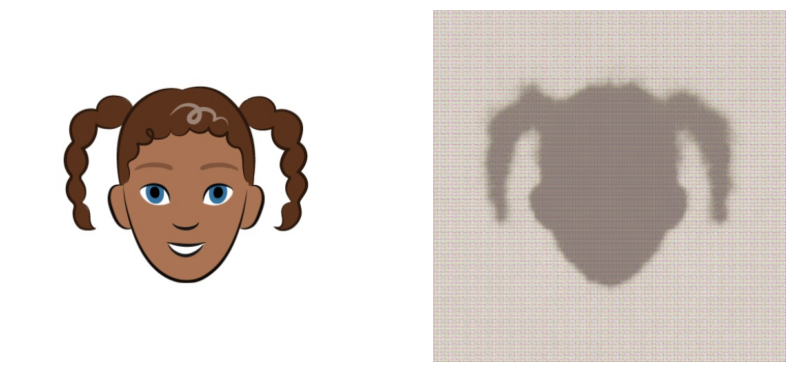

In [9]:
# Running Inference
_, _, _batch_reconstructed = face64(_batch.to(device))
Visualisations.plot_3_channel_images_to_compare(_batch[0], _batch_reconstructed[0])

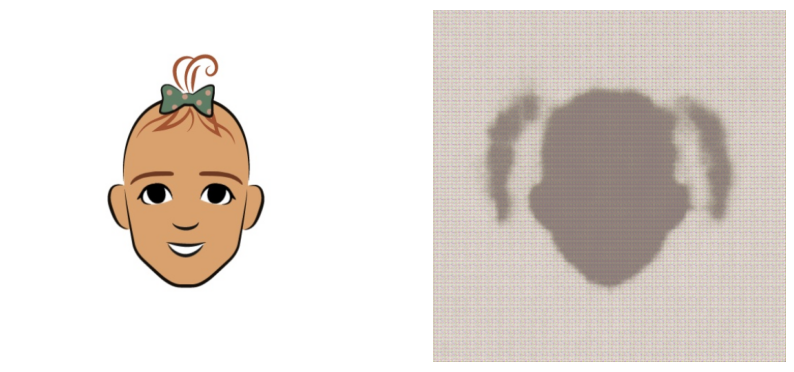

In [12]:
# Using various components of the model independently
_f16_mu, _f16_log_var = face64.encoder(_batch.to(device))
z = face64.sampling(_f16_mu, _f16_log_var)
_batch_reconstructed = face64.decoder(z)
Visualisations.plot_3_channel_images_to_compare(_batch[6], _batch_reconstructed[6])

In [10]:
# Generating Embeddings and reconstructing images
z, l, mu, sigma = face64.generate_embedding(test_loader, device)
_test_reconstructed_from_sample = face64.decoder(z)
Visualisations.show_3_channel_image(_test_reconstructed_from_sample)

RuntimeError: MPS backend out of memory (MPS allocated: 81.43 GB, other allocations: 8.55 MB, max allowed: 81.60 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
Visualisations.plot_2d_embeddings(mu, l)

### Face256

In [30]:
optimiser = torch.optim.Adam(face256.parameters(), lr=0.0005)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.80)
VaeTrainer.train(
    tl=test_loader, 
    vl=val_loader, 
    model=face256, 
    loss_fn=CustomLosses.vae_loss_with_rmse, 
    optimiser=optimiser, 
    scheduler=step_scheduler, 
    epochs=10, 
    device=device
)

VAE Training: 100%|██████████| 79/79 [01:26<00:00,  1.10s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 1, Loss: 18249.553174368943, Validation Loss: 1180.604445831685
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 1: [0.0005]
VAE Training: 100%|██████████| 79/79 [01:21<00:00,  1.04s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 2, Loss: 506.4191542999654, Validation Loss: 211.9937481457674
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 2: [0.0005]
VAE Training: 100%|██████████| 79/79 [01:21<00:00,  1.04s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 3, Loss: 135.36552178105222, Validation Loss: 134.00842458990556
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 3: [0.0005]
VAE Training: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it]
INFO:aicraft.models.AutoEncoderTrainers:Epoch 4, Loss: 103.36381627336333, Validation Loss: 132.4697211543216
INFO:aicraft.models.AutoEncoderTrainers:LRs for epoch 4: [0.0005]
VAE Training: 100%|██████████| 79/79 [01:21<00:0

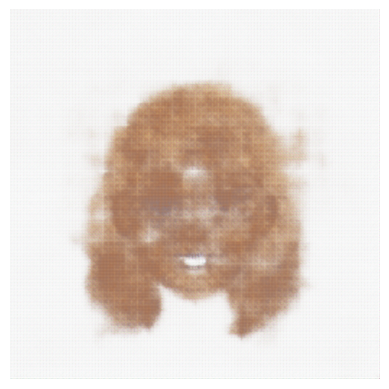

In [31]:
# Running Inference
_, _, _batch_reconstructed = face256(_batch.to(device))
Visualisations.show_3_channel_image(_batch_reconstructed[0])

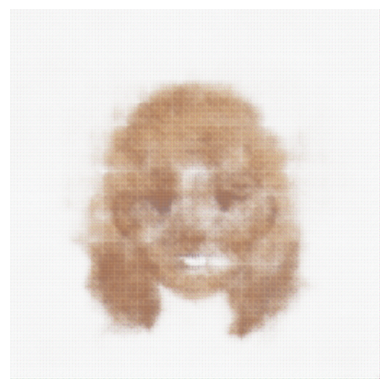

In [32]:
# Using various components of the model independently
_f64_mu, _f64_log_var = face256.encoder(_batch.to(device))
z = face256.sampling(_f64_mu, _f64_log_var)
_batch_reconstructed = face256.decoder(z)
Visualisations.show_3_channel_image(_batch_reconstructed[1])

In [12]:
# Generating Embeddings and reconstructing images
z, l, mu, sigma = face256.generate_embedding(test_loader, device)
_test_reconstructed_from_sample = face256.decoder(z)
Visualisations.show_3_channel_image(_batch_reconstructed[0])

RuntimeError: MPS backend out of memory (MPS allocated: 81.12 GB, other allocations: 8.56 MB, max allowed: 81.60 GB). Tried to allocate 512.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
Visualisations.plot_2d_embeddings(mu, l)